# Testing and Explanations

In [5]:
from typing import Callable, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch_geometric as tg
from IPython.display import display, Image

from miniproject.datamodules import ShapeNetDataModule
from miniproject.models import ShapeNetModel

sns.set_theme()
device = "cuda:2"
torch.set_grad_enabled(False)

best_checkpoints = {
    "gat": "../../runs/miniproject/vivacious-honest-lion/checkpoints/last.ckpt",
    "performer": "../../runs/miniproject/myrtle-gorilla-of-culture/checkpoints/last.ckpt",
}

categories = list(tg.datasets.ShapeNet.category_ids.keys())
seg_classes_colors = torch.tensor(
    [
        mpl.cm.tab10(i)
        for name, classes in tg.datasets.ShapeNet.seg_classes.items()
        for i, c in enumerate(classes)
    ]
)

## Test metrics

Load model for inference and compute test metrics at various levels of resolution (num points):

In [2]:
def load_model(architecture):
    ckpt = best_checkpoints[architecture]
    model = ShapeNetModel.load_from_checkpoint(ckpt)
    model.eval()
    model.to(device)
    model.freeze()
    return model


def test_dataloader(num_points):
    dm = ShapeNetDataModule("../../data", num_points, num_workers=4, batch_size=256)
    dm.setup("test")
    return dm.test_dataloader()


def test_models(resolutions, repeats):
    df = []
    for architecture in best_checkpoints:
        model = load_model(architecture)

        for num_points in resolutions:
            torch.manual_seed(0)
            dl = test_dataloader(num_points)

            # Repeat multiple times since subsampling the points is random
            for _ in range(repeats):
                for batch_idx, batch in enumerate(dl):
                    model.test_step(batch, batch_idx)
                df.append(
                    {
                        "architecture": architecture,
                        "points": num_points,
                        "acc": model.metrics_test.accuracy.compute().item(),
                        "loss": model.metrics_test.loss.compute().item(),
                    }
                )
    return pd.DataFrame(df)


df = test_models(
    repeats=5,
    resolutions=[50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1500],
)

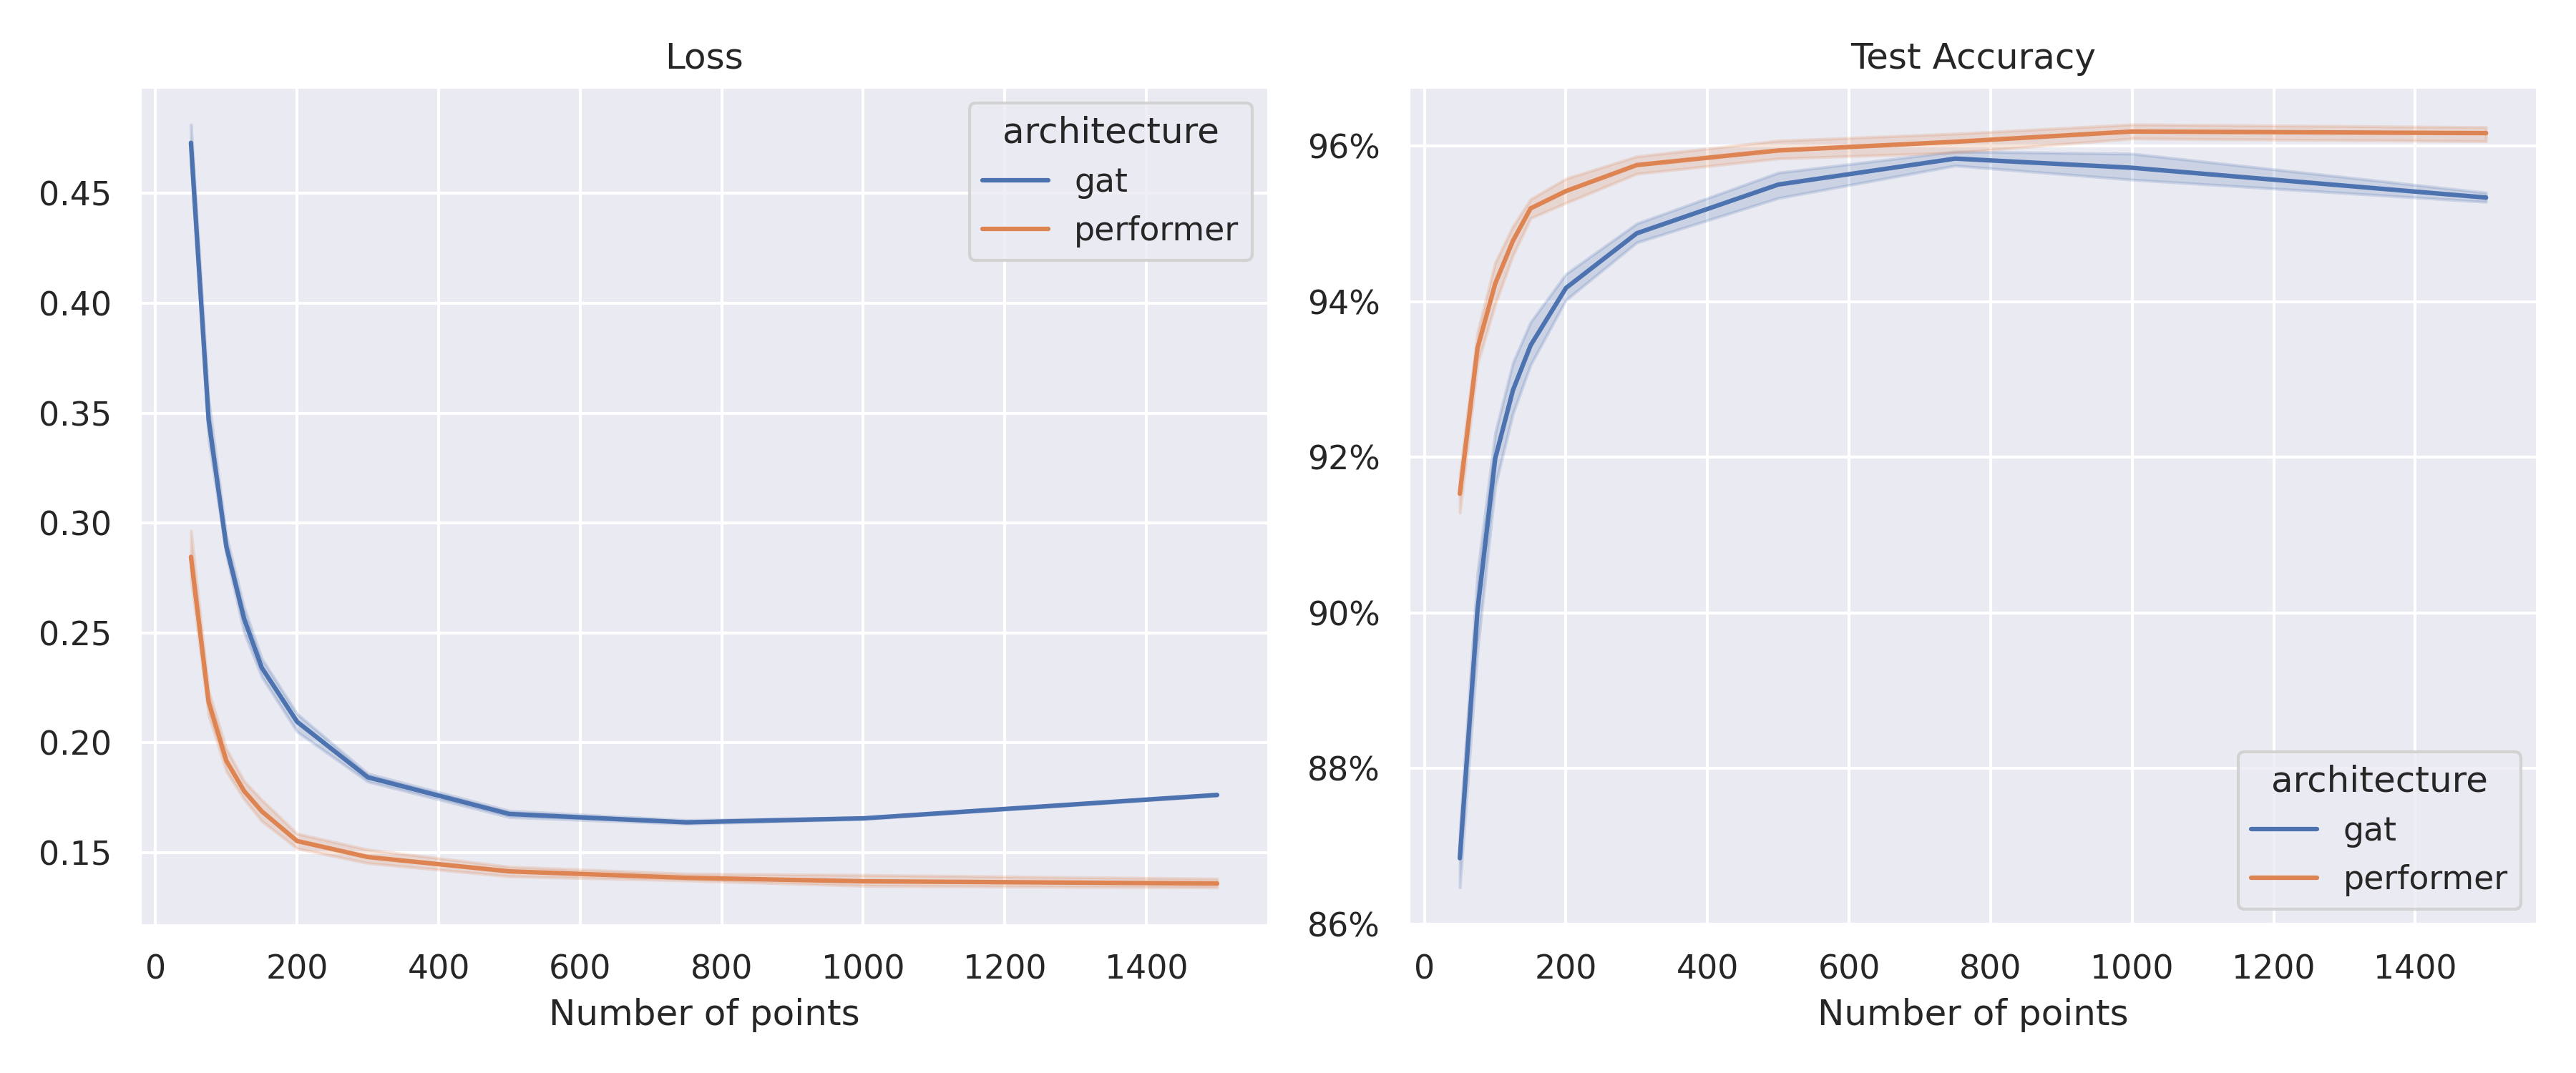

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
sns.lineplot(data=df, x="points", y="loss", hue="architecture", ax=ax)
ax.set(ylabel="", title="Loss", xlabel='Number of points')
ax = axes[1]
sns.lineplot(data=df, x="points", y="acc", hue="architecture", ax=ax)
ax.set(ylabel="", title="Test Accuracy", xlabel='Number of points')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))

fig.tight_layout()
fig.savefig('test_metrics.png', dpi=300)
plt.close(fig)
display(Image('test_metrics.png', width=1000))

## Prediction visualization

Prepare a batch with the first occurence of each category.

In [11]:
class VizBatch(object):
    def __init__(self):
        samples = {}
        for g in tg.datasets.ShapeNet(root="../../data", split="test"):
            if g.category.item() not in samples:
                samples[g.category.item()] = g
                if len(samples) == len(categories):
                    break
        self.samples = tuple(samples.values())

    def __len__(self):
        return len(categories)

    def __call__(self, num_points):
        t = tg.transforms.FixedPoints(num_points, replace=False, allow_duplicates=True)
        batch = tg.data.Batch.from_data_list([t(g.clone()) for g in self.samples])
        return batch


viz_batch = VizBatch()

In [12]:
def scatter3d(g, pred, prob, ax):
    true = categories[g.category.item()]
    pred = categories[pred]
    x, z, y = g.pos.T

    if true == pred:
        title = f"{pred} {prob:.2%}"
        bbox = None
    else:
        title = f"{pred} {prob:.2%} ({true})"
        bbox = dict(facecolor="red", alpha=0.5)
    ax.text2D(
        0.5,
        0.97,
        s=title,
        horizontalalignment="center",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=bbox,
    )

    if "relevance" in g:
        ax.scatter3D(
            x,
            y,
            z,
            marker=".",
            c=g.relevance,
            cmap="Purples",
            # vmin=0,
            # vmax=colors.max().item(),
        )
    else:
        ax.scatter3D(x, y, z, marker=".", c=seg_classes_colors[g.y])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    lim = (g.pos.max(dim=0).values - g.pos.min(dim=0).values).max().item() / 2
    ax.set_xlim3d(-lim, +lim)
    ax.set_ylim3d(-lim, +lim)
    ax.set_zlim3d(-lim, +lim)

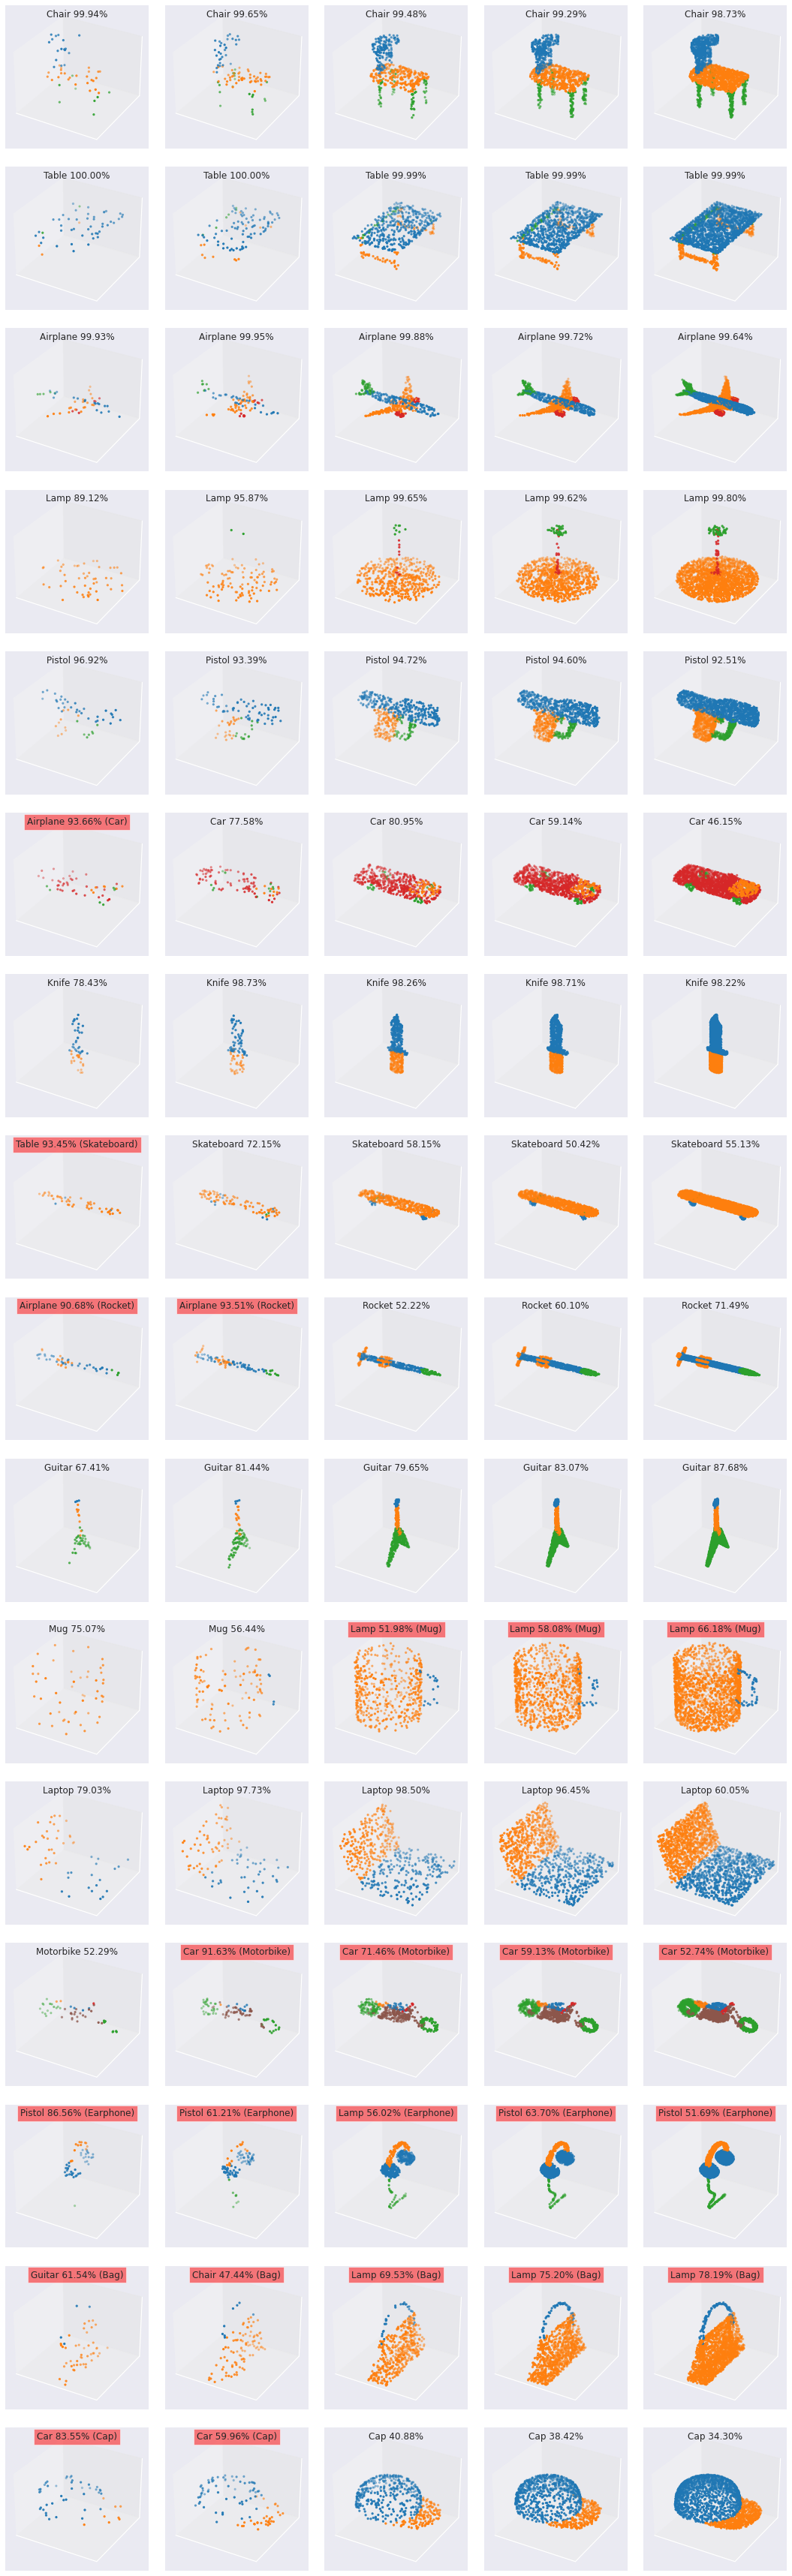

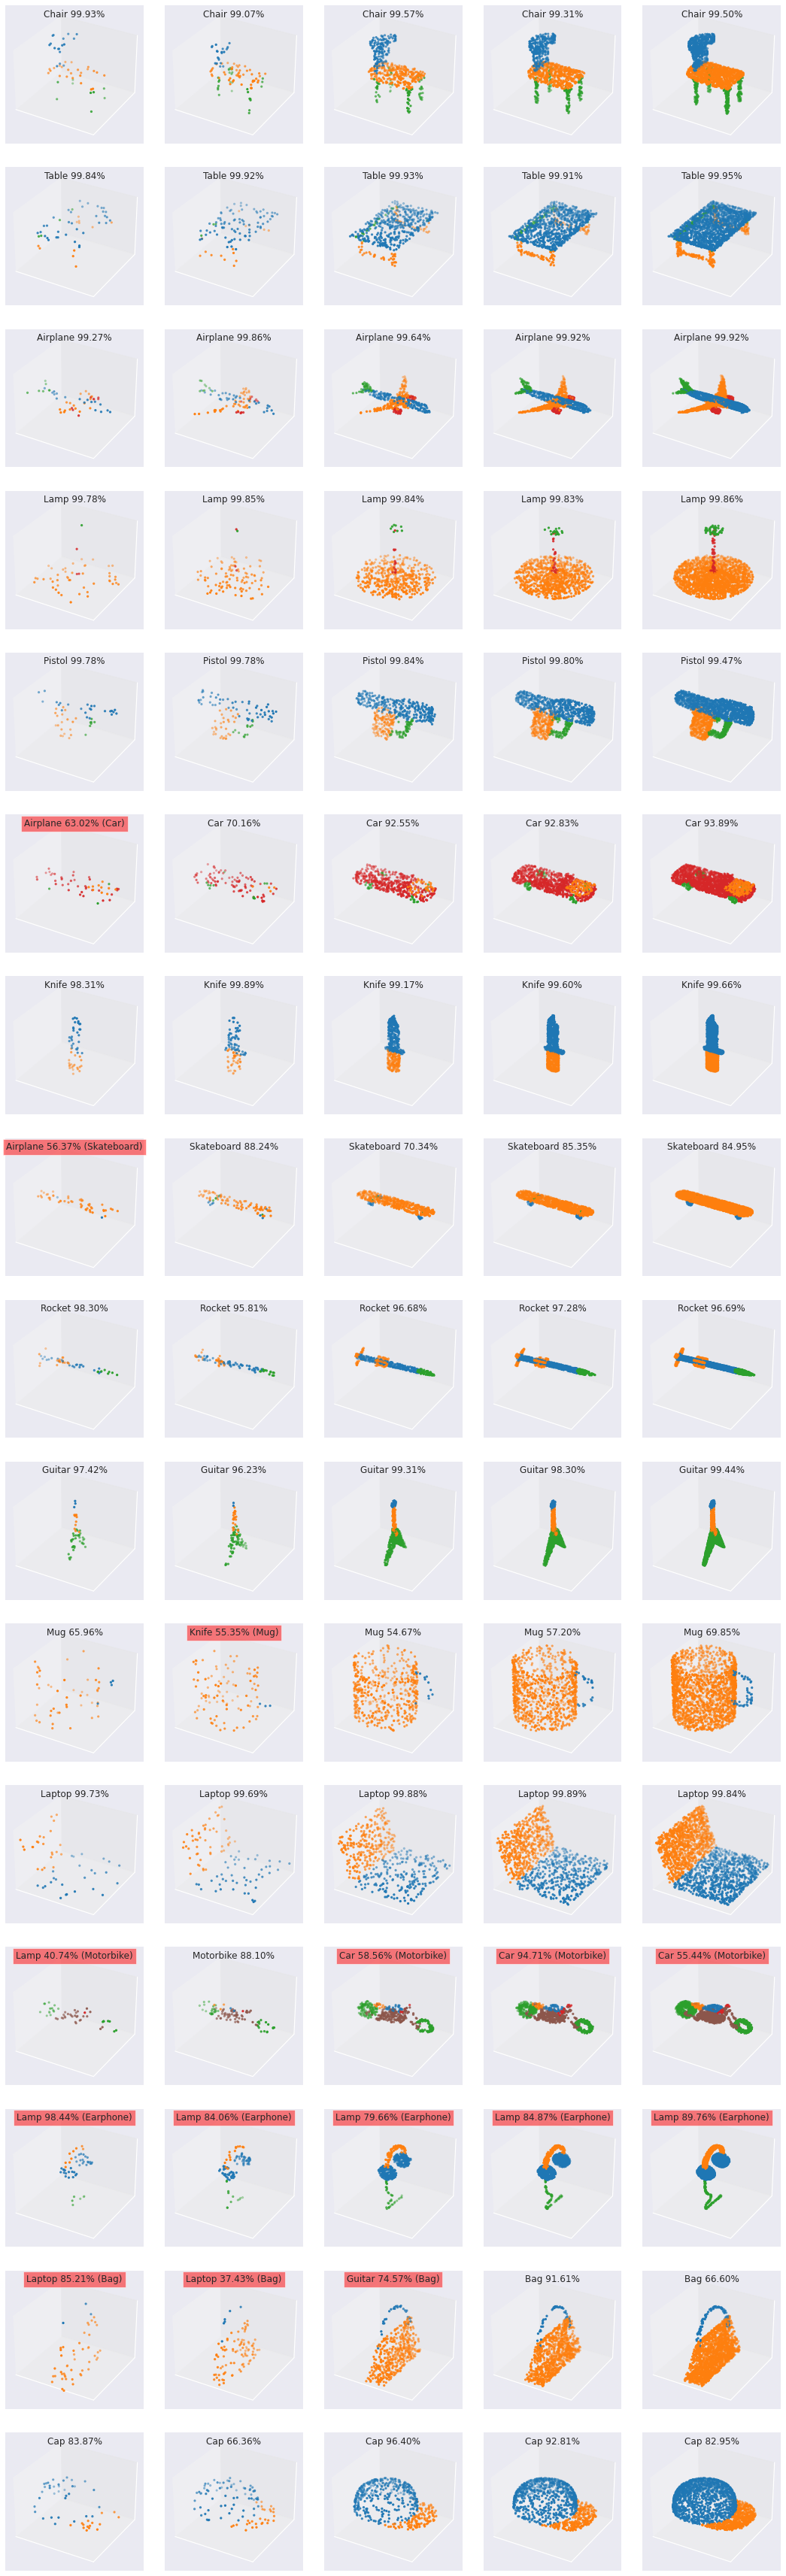

In [13]:
resolutions = [50, 100, 500, 1000, 2000]

for architecture in best_checkpoints:
    model = load_model(architecture)

    fig, axes = plt.subplots(
        len(viz_batch),
        len(resolutions),
        figsize=(len(resolutions) * 3, len(viz_batch) * 3),
        subplot_kw={"projection": "3d"},
    )

    for axes_col, num_points in zip(axes.T, resolutions):
        batch = viz_batch(num_points)
        logits = model(batch)
        probs, preds = logits.softmax(dim=1).max(dim=1)

        batch = batch.to("cpu").to_data_list()
        logits = logits.cpu().numpy()
        probs = probs.cpu().numpy()
        preds = preds.cpu().numpy()

        for g, pred, prob, ax in zip(batch, preds, probs, axes_col):
            scatter3d(g, pred, prob, ax)

    fig.tight_layout()
    display(fig)
    fig.savefig(f"viz-{architecture}.png", dpi=300)
    plt.close(fig)

## Explanation

### Sensitivity Analysis

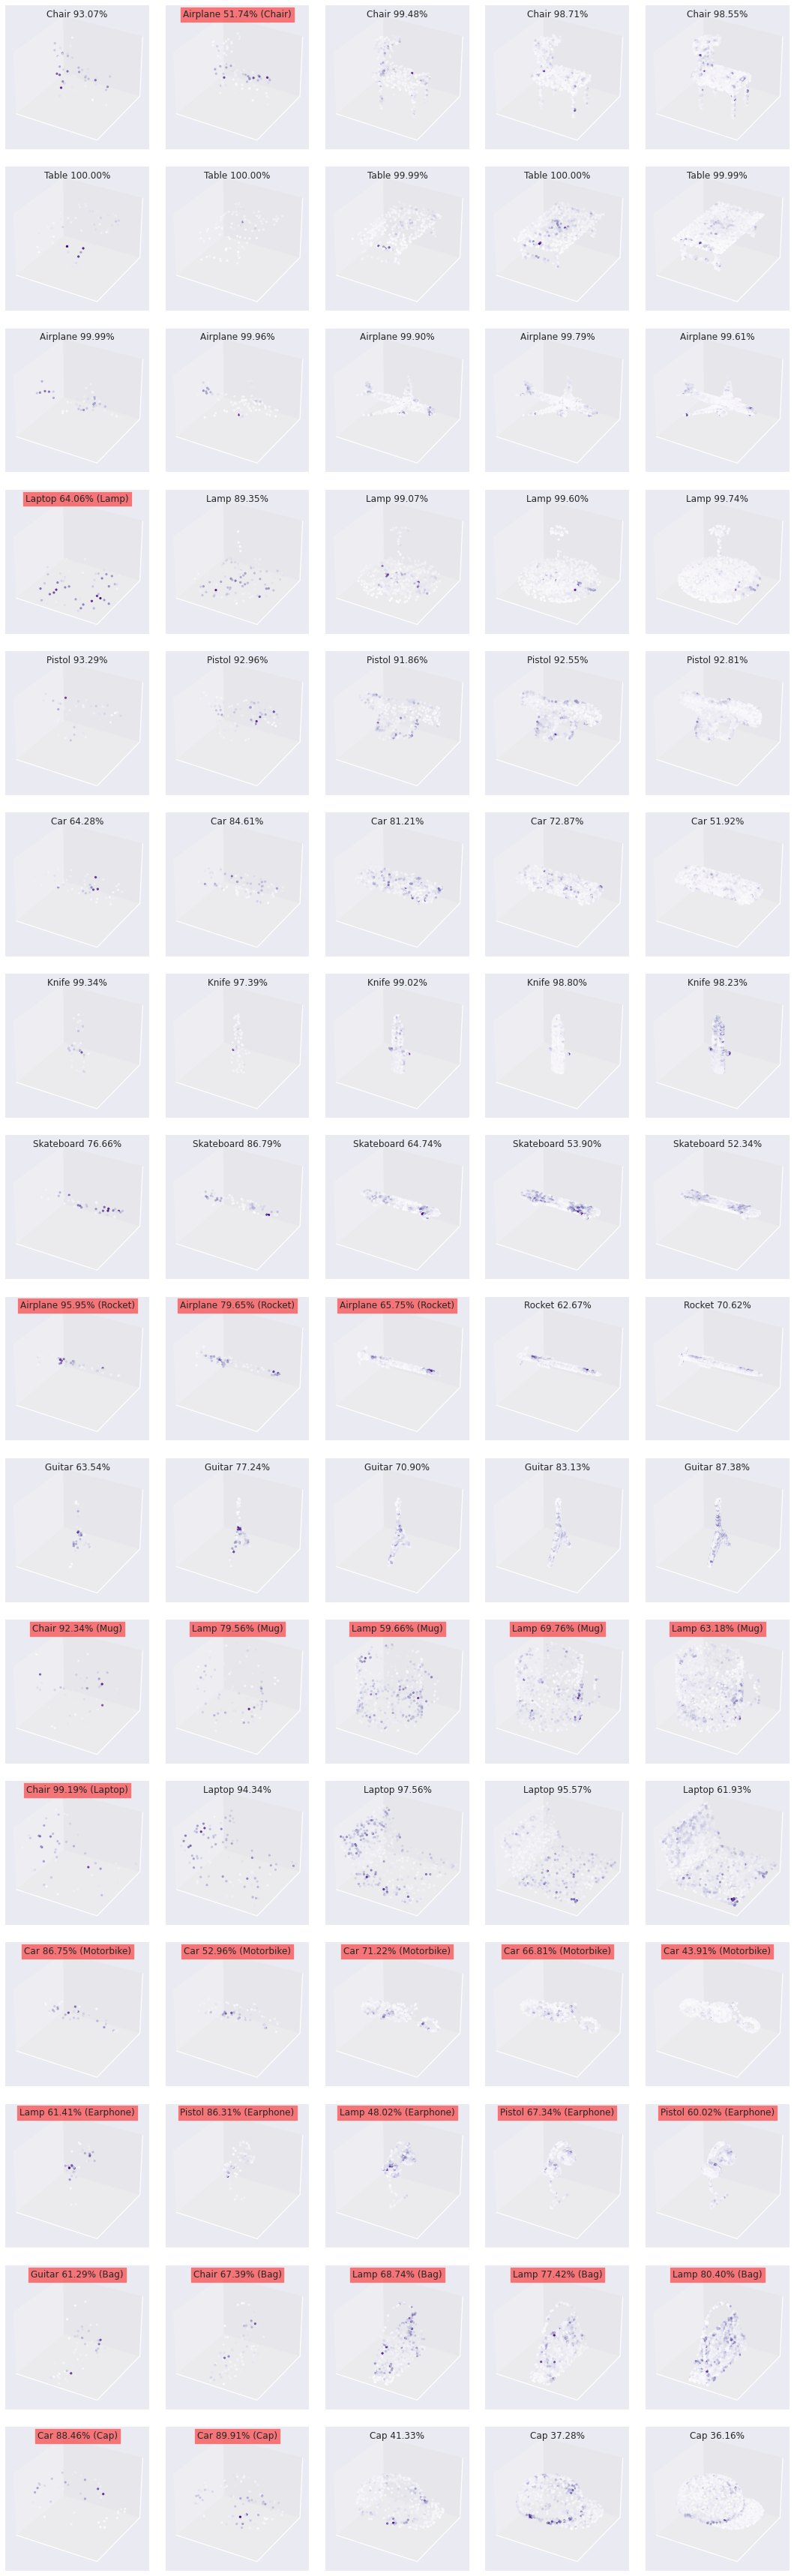

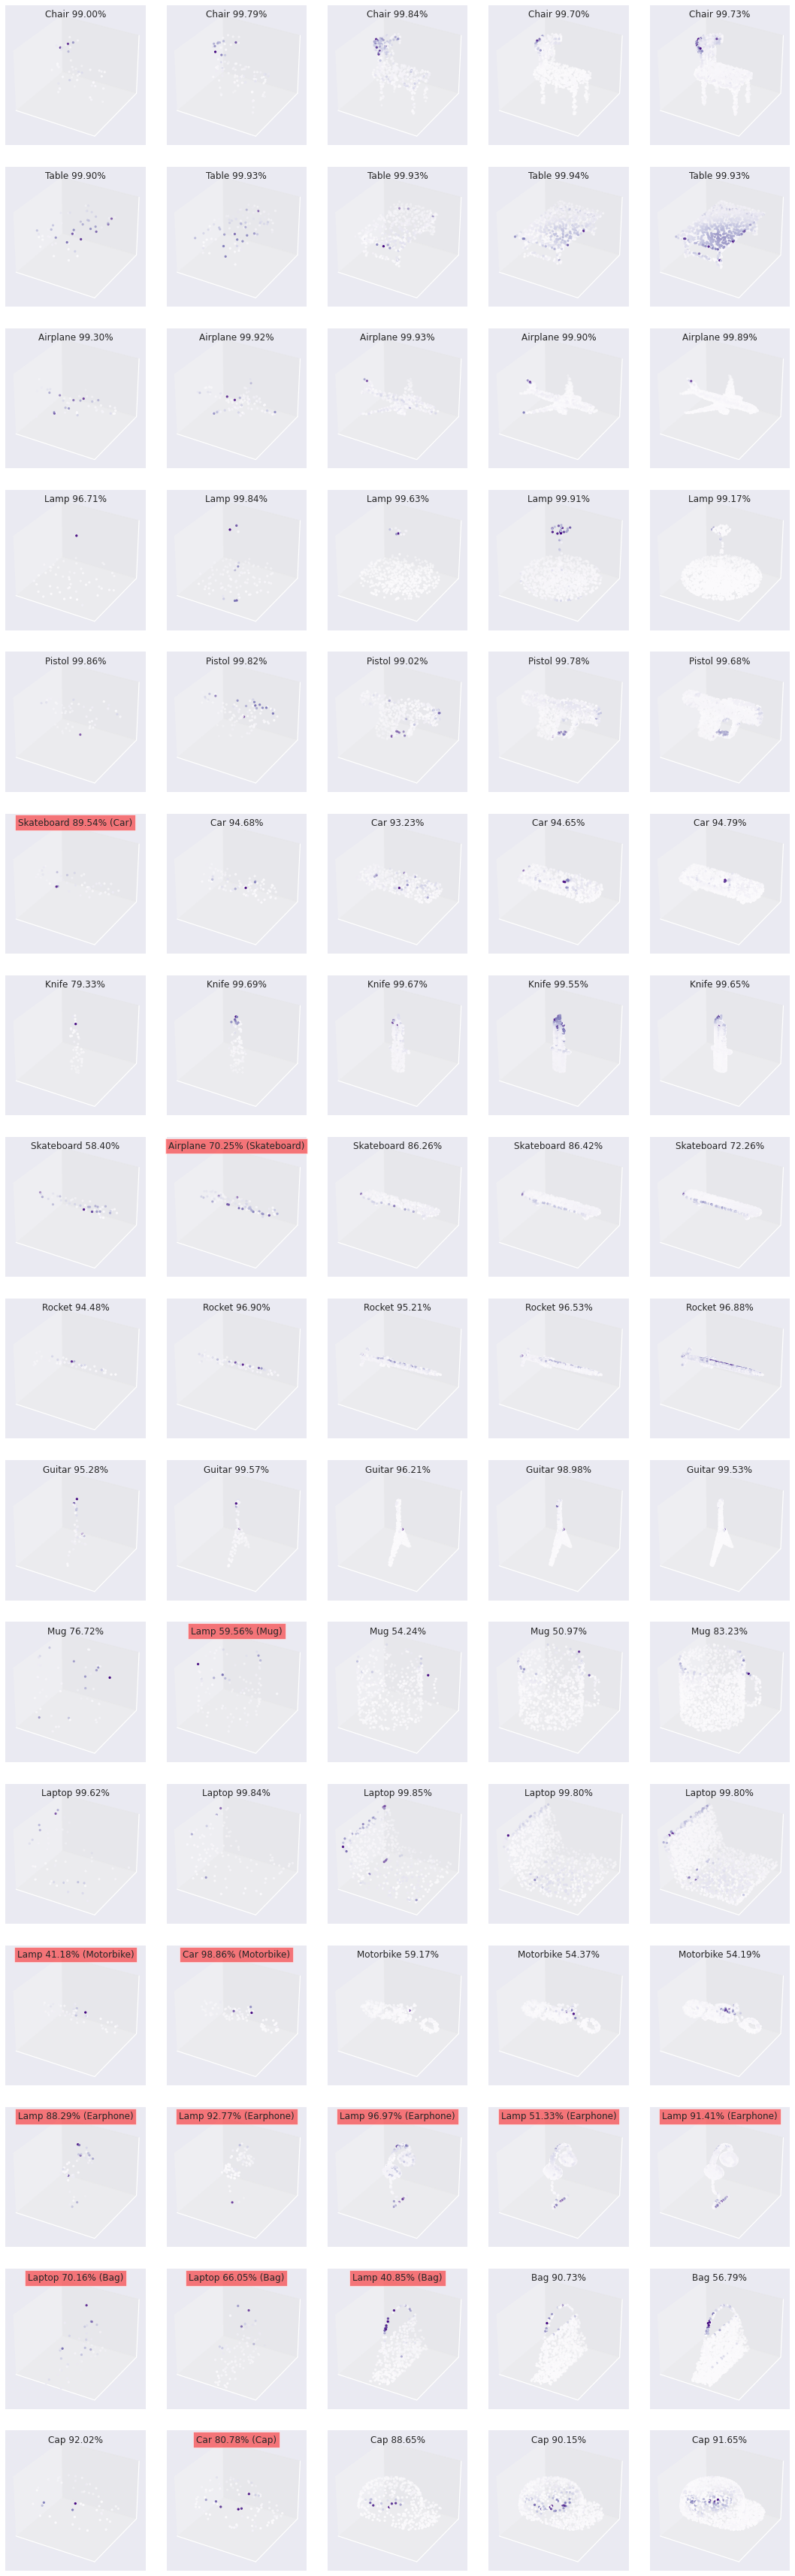

In [14]:
resolutions = [50, 100, 500, 1000, 2000]

for architecture in best_checkpoints:
    model = load_model(architecture)

    fig, axes = plt.subplots(
        len(viz_batch),
        len(resolutions),
        figsize=(len(resolutions) * 3, len(viz_batch) * 3),
        subplot_kw={"projection": "3d"},
    )

    for axes_col, num_points in zip(axes.T, resolutions):
        with torch.enable_grad():
            batch = viz_batch(num_points)
            batch.x.requires_grad_()
            batch.pos.requires_grad_()
            logits = model(batch)
            probs, preds = logits.softmax(dim=1).max(dim=1)
            probs.backward(torch.ones_like(probs))

        # If not copied, batch.pos.grad disappears when calling to_data_list()
        batch.relevance = torch.cat((batch.x.grad, batch.pos.grad), dim=1).norm(dim=1)
        batch.__slices__["relevance"] = batch.__slices__["pos"]
        batch.__cat_dims__["relevance"] = batch.__cat_dims__["pos"]
        batch.__cumsum__["relevance"] = batch.__cumsum__["pos"]
        batch.pos.requires_grad_(False)
        batch.x.requires_grad_(False)
        batch.to("cpu")
        batch = batch.to_data_list()

        logits = logits.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()

        for g, pred, prob, ax in zip(batch, preds, probs, axes_col):
            scatter3d(g, pred, prob, ax)

    fig.tight_layout()
    display(fig)
    fig.savefig(f"sensitivity-{architecture}.png", dpi=300)
    plt.close(fig)

### GradCAM

Backward hook for GradCAM, set on the output of the performer/gat module, before global average pooling

In [15]:
BackwardHookFn = Callable[[torch.Tensor, torch.Tensor], Optional[torch.Tensor]]


def one_time_tensor_hook(tensor: torch.Tensor, backward_hook_fn: BackwardHookFn):
    """Register a one time tensor hook that will receive both the tensor and the grad"""

    def inner(grad: torch.Tensor) -> Optional[torch.Tensor]:
        try:
            new_grad = backward_hook_fn(tensor, grad)
            return new_grad
        finally:
            handle.remove()

    handle = tensor.register_hook(inner)


class GradCam(BackwardHookFn):
    def __init__(self):
        self.relevances = None

    def __call__(self, tensor: torch.Tensor, grad: torch.Tensor) -> None:
        # tensor/grad [num_graphs, num_nodes, num_features]
        alphas = grad.mean(dim=1, keepdim=True)
        self.relevances = (alphas * tensor).sum(dim=2).relu()


class GradCamGat(BackwardHookFn):
    def __init__(self, num_nodes):
        self.relevances = None
        self.num_nodes = num_nodes

    def __call__(self, tensor: torch.Tensor, grad: torch.Tensor) -> None:
        # [num_graphs * num_nodes, num_features] -> [num_graphs, num_nodes, num_features]
        grad = grad.view(grad.shape[0] // self.num_nodes, self.num_nodes, -1)
        tensor = tensor.view(tensor.shape[0] // self.num_nodes, self.num_nodes, -1)
        alphas = grad.mean(dim=1, keepdim=True)
        self.relevances = (alphas * tensor).sum(dim=2).relu()

Run grad cam at multiple resolutions

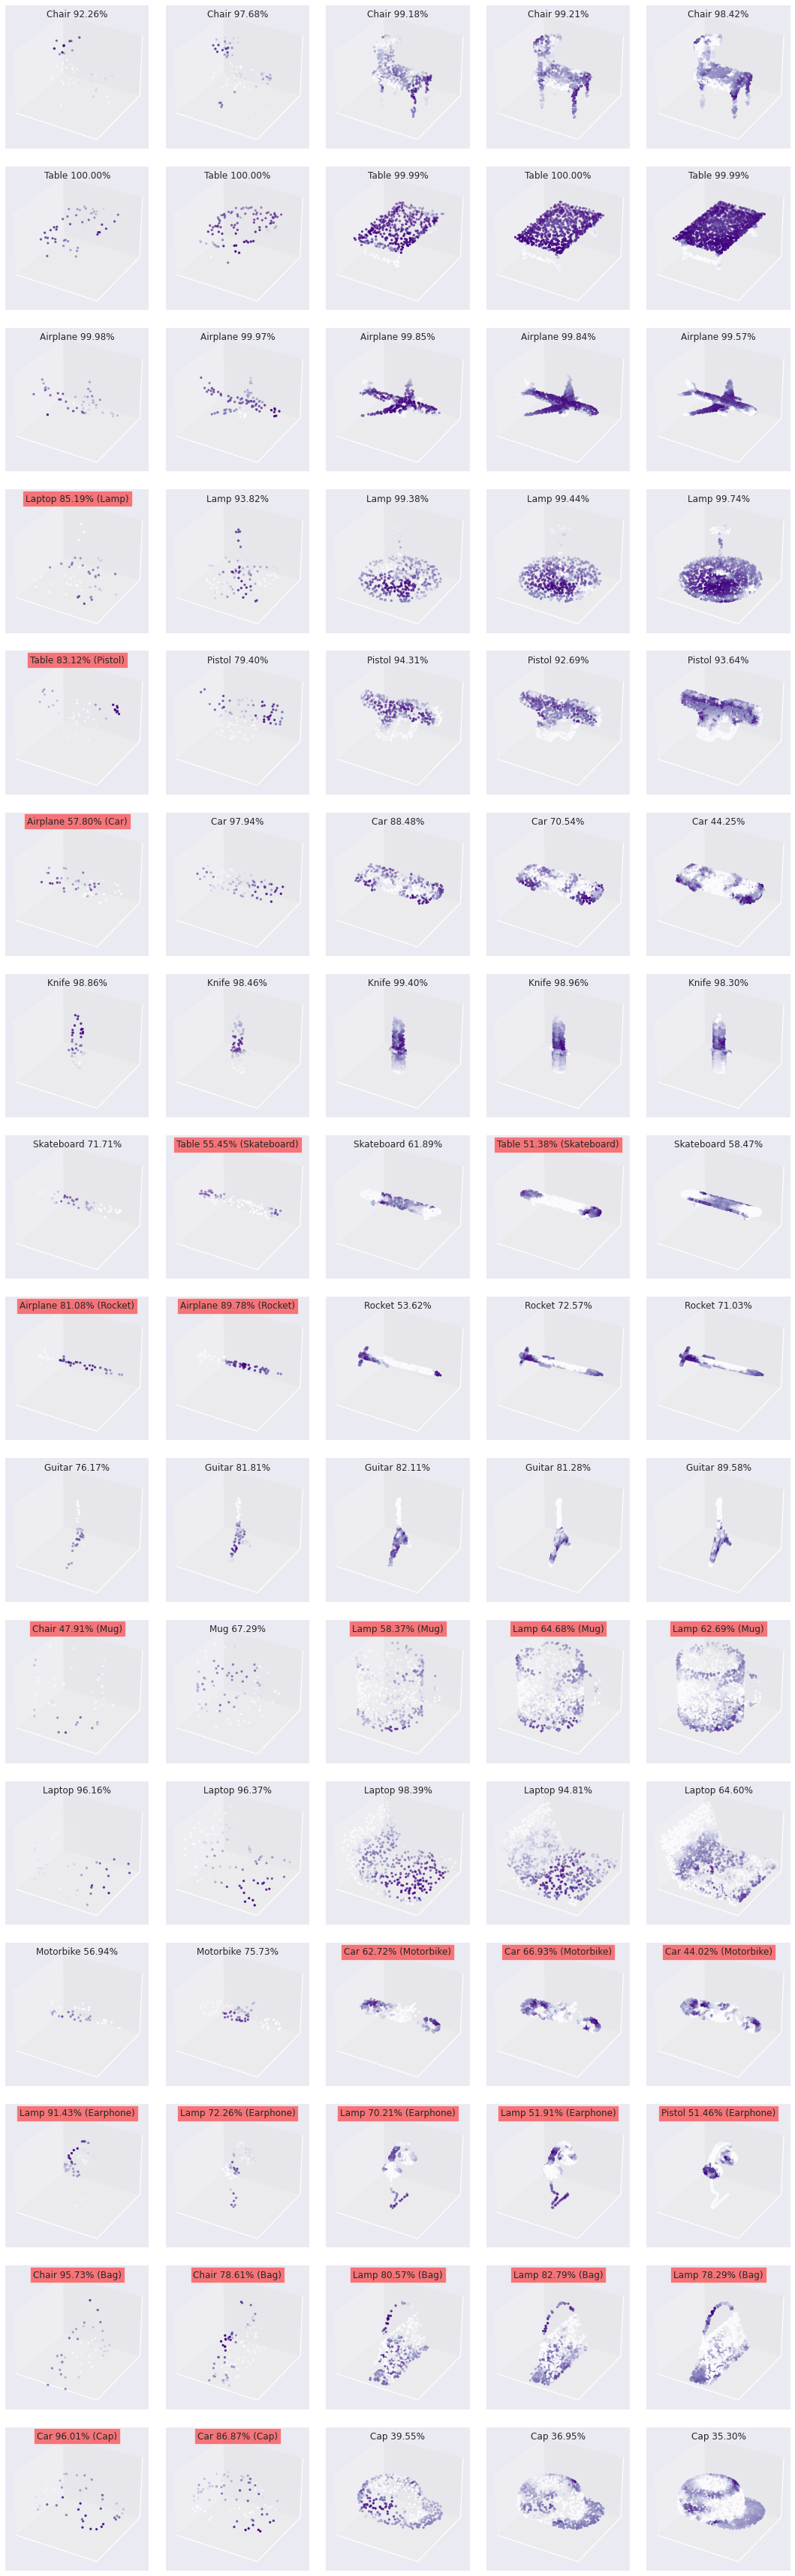

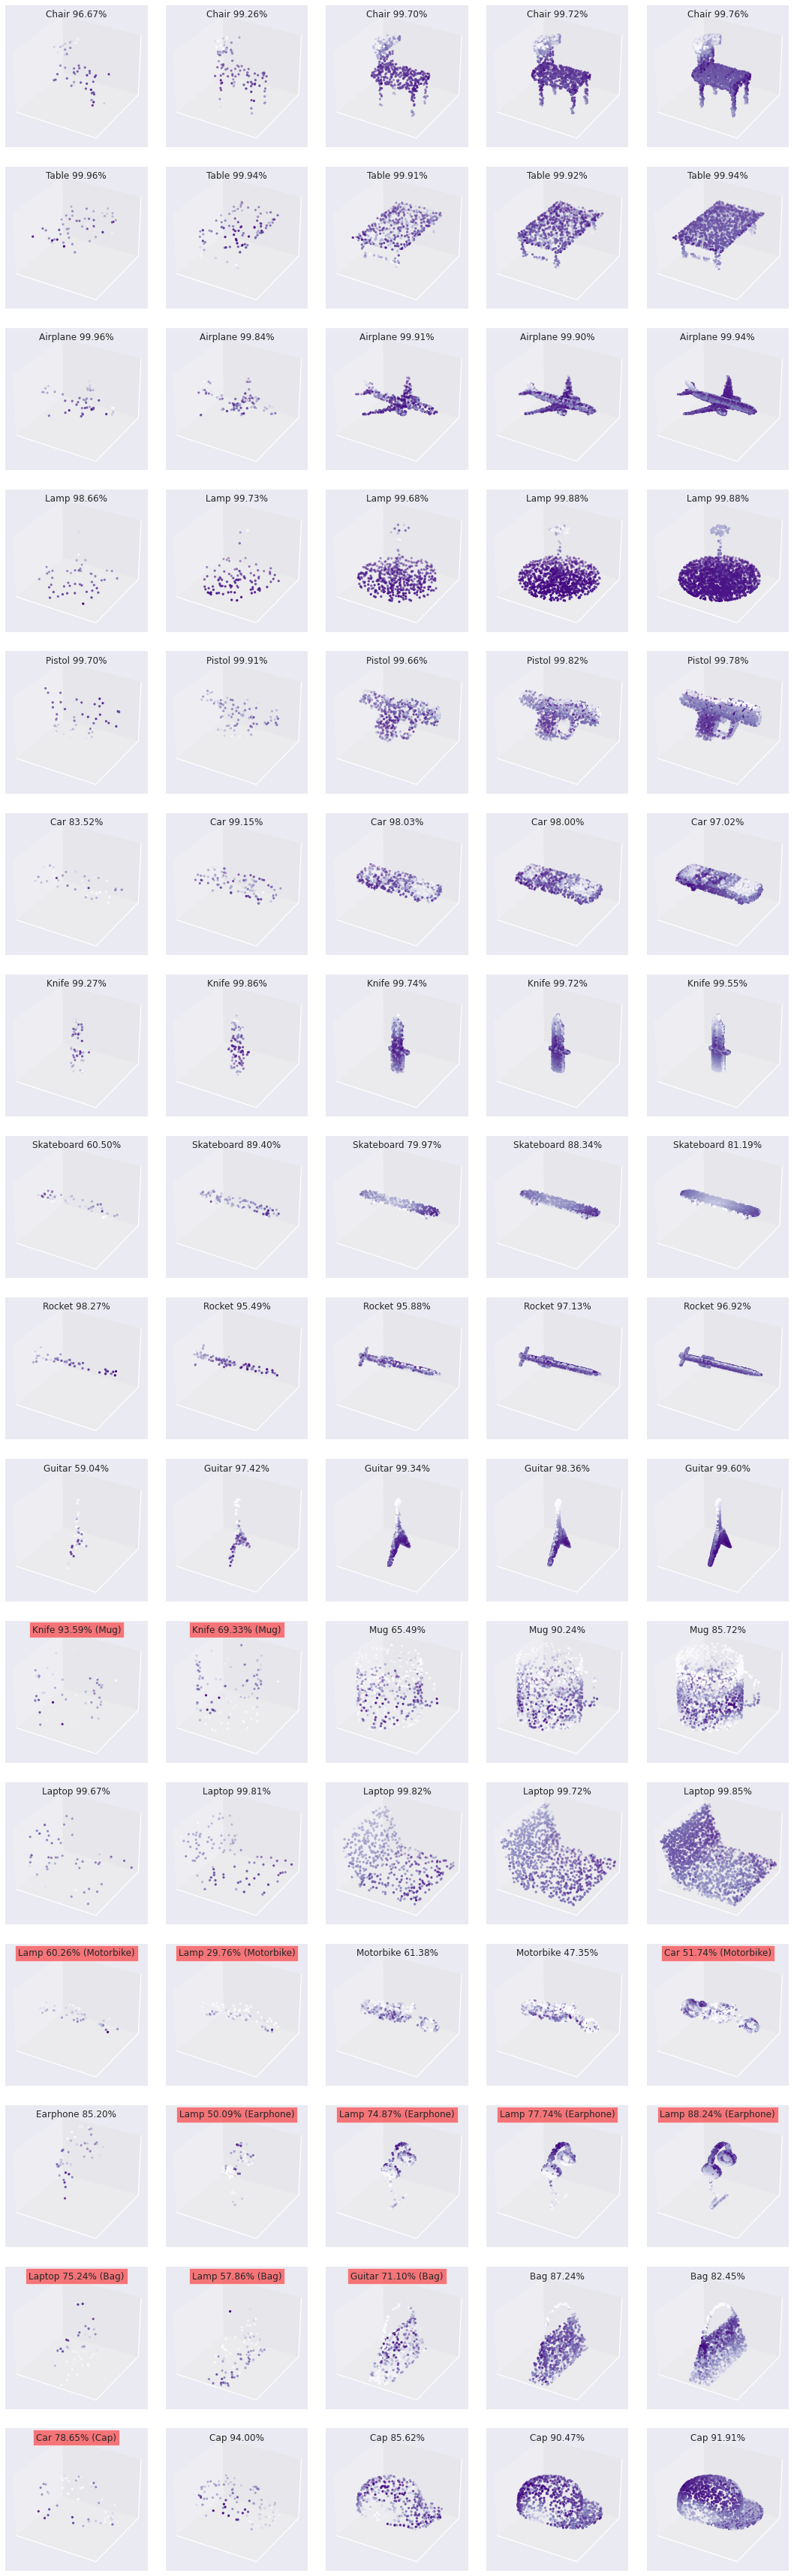

In [16]:
resolutions = [50, 100, 500, 1000, 2000]

for architecture in best_checkpoints:
    model = load_model(architecture)

    fig, axes = plt.subplots(
        len(viz_batch),
        len(resolutions),
        figsize=(len(resolutions) * 3, len(viz_batch) * 3),
        subplot_kw={"projection": "3d"},
    )

    for axes_col, num_points in zip(axes.T, resolutions):
        with torch.enable_grad():
            if architecture == "performer":
                gc = GradCam()
                fh = lambda m, i, o: one_time_tensor_hook(o, gc)
                handle = model.model.transformer.register_forward_hook(fh)
            elif architecture == "gat":
                gc = GradCamGat(num_points)
                fh = lambda m, i, o: one_time_tensor_hook(o, gc)
                handle = model.model.gat.register_forward_hook(fh)
            else:
                raise ValueError(architecture)

            batch = viz_batch(num_points)
            batch.pos.requires_grad_()

            logits = model(batch)
            probs, preds = logits.softmax(dim=1).max(dim=1)

            probs.backward(torch.ones_like(probs))
            handle.remove()

        # If not copied, batch.relevance disappears when calling to_data_list()
        batch.relevance = gc.relevances.view(-1, 1)
        batch.__slices__["relevance"] = batch.__slices__["pos"]
        batch.__cat_dims__["relevance"] = batch.__cat_dims__["pos"]
        batch.__cumsum__["relevance"] = batch.__cumsum__["pos"]
        batch.pos.requires_grad_(False)
        batch.to("cpu")
        batch = batch.to_data_list()

        logits = logits.detach().cpu().numpy()
        probs = probs.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()

        for g, pred, prob, ax in zip(batch, preds, probs, axes_col):
            scatter3d(g, pred, prob, ax)

    fig.tight_layout()
    display(fig)
    fig.savefig(f"gradcam-{architecture}.png", dpi=300)
    plt.close(fig)